In [87]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('paper', font_scale=1.3)
red, blue, green = sns.color_palette('Set1', 3)

import os
from datetime import datetime, timedelta
from rakott.mpl import savefig_bbox

In [29]:
from inference import *

def τ_to_string(τ):
    return (pd.to_datetime(start_date) + timedelta(days=τ)).strftime('%b %d')

def generate(Z, D, μ, β1, α1, λ, α2, E0, Iu0, τ, ndays, Td1, Td2, N):
    τ = int(τ)
    S, E, Ir, Iu, R, Y = simulate(Z, D, μ, β1, α1, λ, α2, E0, Iu0, τ, ndays, N)
    p1 = 1/Td1
    p2 = 1/Td2 
    C = np.zeros_like(Y)
    for t in range(1, len(C)):
        p = p1 if t < τ else p2
        n = Y[t] - C[:t].sum()
        n = max(0,n)
        C[t] = np.random.poisson(n * p)     

    return C

country_name = 'Italy'

In [30]:
url = 'https://github.com/ImperialCollegeLondon/covid19model/raw/v1.0/data/COVID-19-up-to-date.csv'
fname = '../data/COVID-19-up-to-date.csv'
if not os.path.exists(fname):
    urllib.request.urlretrieve(url, fname)
df = pd.read_csv(fname, encoding='iso-8859-1')
df['date'] = pd.to_datetime(df['dateRep'], format='%d/%m/%Y')
df = df[df['countriesAndTerritories'] == country_name]
N = df.iloc[0]['popData2018']
cases_and_dates = df.iloc[::-1][['cases','date']]
start_date = find_start_day(cases_and_dates)
X = np.array(cases_and_dates[cases_and_dates['date'] >= start_date]['cases'])
ndays = len(X)

In [31]:
output_folder = '../output/2020-04-28'
npz_path = os.path.join(output_folder, 'inference', '{}.npz')
data = np.load(npz_path.format(country_name))
var_names = data['var_names']
start_date = data['start_date']
chain = data['chain']

In [32]:
τ_star = official_τ_dates[country_name]
τ_star = (τ_star - pd.to_datetime(start_date)).days

In [33]:
nwalkers, nsteps, ndim = chain.shape
θ = chain[:, nsteps//2, :].mean(axis=0)
τ_hat = int(θ[-1])

In [39]:
ndays = max(τ_star, τ_hat) + 7 + 1
X_hat = np.mean([generate(*θ[:-1], τ_hat, ndays=ndays, Td1=Td1, Td2=Td2, N=N) for _ in range(300)], axis=0)
X_star = np.mean([generate(*θ[:-1], τ_star, ndays=ndays, Td1=Td1, Td2=Td2, N=N) for _ in range(300)], axis=0)

τ*=18, τ_hat=23
3903.0
2361.0


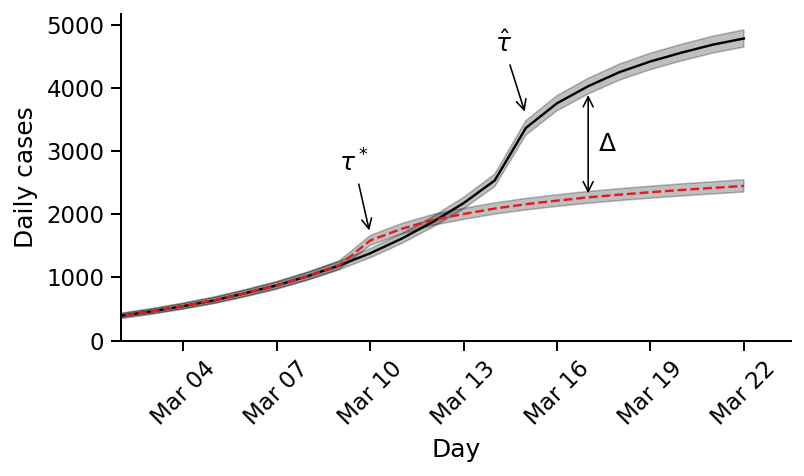

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True, sharey=True)
print('τ*={}, τ_hat={}'.format(τ_star, τ_hat))

ax.plot(X_hat, '-k')
low, high = scipy.stats.poisson(X_hat).interval(0.95)
print(low[τ_star+7])
ax.fill_between(range(ndays), low, high, alpha=0.25, color='k')

ax.plot(X_star, ls='--', color=red)
low, high = scipy.stats.poisson(X_star).interval(0.95)
print(high[τ_star+7])
ax.fill_between(range(ndays), low, high, alpha=0.25, color='k')

x0, y0 = τ_star, X_hat[τ_star]+300
ax.annotate(r"$\tau^*$", xy=(x0, y0), xytext=(x0-1, y0+1000), 
            xycoords='data',
            arrowprops=dict(arrowstyle="->"))
x0, y0 = τ_hat, X_hat[τ_hat]+200
ax.annotate(r"$\hat{\tau}$", xy=(x0, y0), xytext=(x0-1, y0+1000), 
            xycoords='data',
            arrowprops=dict(arrowstyle="->"))
x0, y0 = τ_star+7, X[τ_star+7]
x1, y1 = τ_star+7, X_star[τ_star+7]
ax.annotate("", xy=(x0, y0-50), xytext=(x1, y1), 
            xycoords='data',
            arrowprops=dict(arrowstyle="<->"))
ax.annotate(r"$\Delta$", xy=(x0+0.5, (y1+y0)/2), xytext=(x1+0.3, (y1+y0)*0.48))

days = list(range(0, ndays, round(ndays/10)))
labels = [τ_to_string(d) for d in days]
ax.set_xticks(days)
txt = ax.set_xticklabels(labels, rotation=45)
ax.set(xlabel='Day', 
       ylabel='Daily cases',
       xlim=(10, ndays+0.5),
       ylim=(0, None),
)
sns.despine()
fig.savefig('../figures/Fig4.pdf', **savefig_bbox(*txt))

In [85]:
(3903-2361)/3903

0.3950807071483474